# ECE 590, Fall 2019 
## Problem Set 6

## Full name: Jessica Centers


In [54]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import imageio
import os
from torchvision.utils import save_image
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression

### Problem 1 Bayesian Network

#### Indicate whether the following statements are true or false and explain why.
$\newcommand{\indep}{\perp \!\!\! \perp}$
$(H\indep L)|P$: False  
Given P, L and H are dependent of each other via G still.  
$(H\indep L)|P,G$: True  
Given P and G, L and H are independent and therefore do not route to each other on the graphical model without going through P and G.  
$(P\indep D)|G$: True  
Given G, P and D are independent and therefore do not route to each other on the graphical model without going through G.  
$(H\indep D)|L$: True  
Given anything or nothing, D and H are independent of each other. Graphically, you cannot follow a path from one leading to another even though they both do parent node G.
  
#### Write down the fctorized form of the joint distribution Pr(H,D,P,G,L).
$$Pr(H,D,P,G,L) = Pr(D)Pr(H)Pr(P|H,G)Pr(G|H,D)Pr(L|P,G)$$  

#### Write down the expression for the probability of obtaining the letter of recommendation Pr(L=1) using G in {A,B} and P in {A,B}. Compute Pr(L=1) using the provided probability tables.
$$Pr(L=1) = \sum_{i=1}^{2}\sum_{j=1}^{2} Pr(P=P_{i},G=G_{j})Pr(L=1|P=P_{i},G=G_{j})$$
$$Pr(L=1) = 0.4(0.8)+0.3(0.6)+0.1(0.3)+0.2(0.1) = 0.55$$

### Problem 2 Image Denoising using Singular Value Decomposition

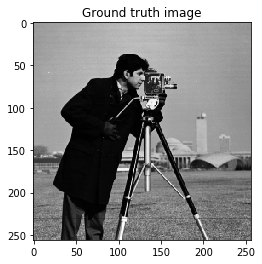

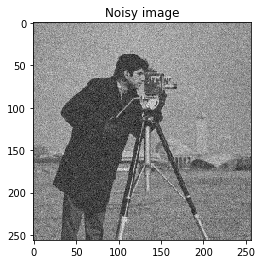

In [46]:
# reading the ground truth image 
im = imageio.imread('cameraman.png')

# normalize the image 
im = (im - np.min(im))/(np.max(im) - np.min(im))

# visualize the image 
plt.imshow(im, cmap="gray")
plt.title("Ground truth image")
plt.show()

# add some noise to the image 
n = 0.1 * np.random.randn(256,256)

# noisy image
im_noisy = im + n

# visualize the image 
plt.imshow(im_noisy, cmap="gray")
plt.title("Noisy image")
plt.show()

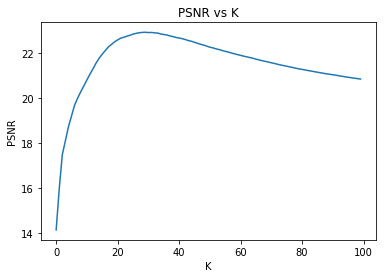

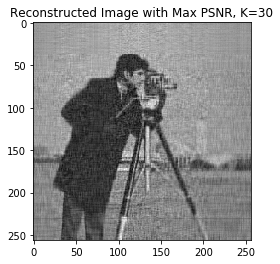

In [47]:
# calculate PSNR for all K values
max_im = im.max()
m, n = im.shape
u, s, vh = np.linalg.svd(im_noisy)
max_K = 100
psnr = np.zeros(max_K)
for K in range(max_K):
    new_im = np.matrix(u[:, :K+1]) * np.diag(s[:K+1]) * np.matrix(vh[:K+1, :])
    mse = (1/(m*n))*np.sum(np.square((im-new_im)))
    psnr[K] = 10*np.log10([max_im**2/mse])

# plot PSRN vs K
plt.plot(np.arange(max_K),psnr)
plt.title("PSNR vs K")
plt.xlabel("K")
plt.ylabel("PSNR")
plt.show()

# max PSNR reconstructed image
max_psnr = psnr.max()
index = np.where(psnr==max_psnr)
index = index[0][0]
new_im = np.matrix(u[:, :index]) * np.diag(s[:index]) * np.matrix(vh[:index, :]) 
plt.imshow(new_im, cmap="gray")
plt.title("Reconstructed Image with Max PSNR, K={}".format(index+1))
plt.show()


### Problem 3 Feature Extraction using Autoencoder

In [48]:
device = 'cpu'

In [113]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.enc_lin1 = nn.Linear(784, 128)
        self.enc_lin2 = nn.Linear(128, 64)
        self.enc_lin3 = nn.Linear(64, 12)
        self.enc_lin4 = nn.Linear(12, 3)

        self.dec_lin1 = nn.Linear(3, 12)
        self.dec_lin2 = nn.Linear(12, 64)
        self.dec_lin3 = nn.Linear(64, 128)
        self.dec_lin4 = nn.Linear(128, 784)
    
    def forward(self, x):
        x = F.relu(self.enc_lin1(x))
        x = F.relu(self.enc_lin2(x))
        x = F.relu(self.enc_lin3(x))
        x = (self.enc_lin4(x))
        x = F.relu(self.dec_lin1(x))
        x = F.relu(self.dec_lin2(x))
        x = F.relu(self.dec_lin3(x))
        x = torch.tanh(self.dec_lin4(x))
        return x

In [114]:
batch_size = 128
Num_epoch = 20
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])
Datset = torchvision.datasets.MNIST(root='./mnist', train=True, download=True, transform=transform)
DataLoader = torch.utils.data.DataLoader(Datset, batch_size=batch_size, shuffle=True, num_workers=0)
Datset_test = torchvision.datasets.MNIST(root='./mnist', train=False, download=True, transform=transform)
DataLoader_test = torch.utils.data.DataLoader(Datset_test, batch_size=100, shuffle=True, num_workers=0)

def Array_to_Image(x):
    x = 0.5*x + 0.5
    x = x.view(x.size(0), 1, 28, 28)
    return x
if not os.path.exists('./Image_gen'):
    os.mkdir('./Image_gen')

In [115]:
# AE
model = AutoEncoder()
model = model.to(device)
criterion  = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr= 1e-3, weight_decay= 1e-4)

In [105]:
min_loss = 10e+10
for epoch in range(Num_epoch):
    running_loss = 0 
    for batch_ind, (image,_) in enumerate(DataLoader):
        image = image.to(device)
        optimizer.zero_grad()
        data = image.view(-1, 28*28)
        output = model(data)
        loss = criterion(data, output)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print('Epoch {}: Loss: {:.4f}'.format(epoch, running_loss/(batch_ind+1)))
    Img = Array_to_Image(output)
    save_image(Img, './Image_gen/Im_{}.png'.format(epoch))
    if (running_loss/(batch_ind+1)) < min_loss:
        torch.save(model, 'ckpt_autoencoder.pth')
        min_loss = running_loss/(batch_ind+1)

Epoch 0: Loss: 0.2475


C:\Users\jessi\Anaconda3\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type AutoEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch 1: Loss: 0.1868
Epoch 2: Loss: 0.1713
Epoch 3: Loss: 0.1634
Epoch 4: Loss: 0.1590
Epoch 5: Loss: 0.1559
Epoch 6: Loss: 0.1535
Epoch 7: Loss: 0.1517
Epoch 8: Loss: 0.1501
Epoch 9: Loss: 0.1485
Epoch 10: Loss: 0.1468
Epoch 11: Loss: 0.1458
Epoch 12: Loss: 0.1448
Epoch 13: Loss: 0.1440
Epoch 14: Loss: 0.1429
Epoch 15: Loss: 0.1421
Epoch 16: Loss: 0.1416
Epoch 17: Loss: 0.1408
Epoch 18: Loss: 0.1404
Epoch 19: Loss: 0.1398


In [152]:
iter_train = iter(DataLoader)
image_train, label_train = next(iter_train)
image_train = image_train.view(-1, 28*28)
output = model(image_train)
output = output.detach()
clf = LogisticRegression(multi_class='multinomial',solver='lbfgs').fit(output, label_train)
print('Mean train accuracy of Autoencoder/Decoder classification:')
clf.score(output, label_train)

Mean train accuracy of Autoencoder/Decoder classification:


0.234375

In [153]:
iter_test = iter(DataLoader_test)
image_test, label_test = next(iter_test)
image_test = image_test.view(-1, 28*28)
output = model(image_test)
output = output.detach()
clf = LogisticRegression(multi_class='multinomial',solver='lbfgs').fit(output, label_test)
print('Mean test accuracy of Autoencoder/Decoder classification:')
clf.score(output, label_test)

Mean test accuracy of Autoencoder/Decoder classification:


0.17

In [162]:
# CAE
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.enc_lin1 = nn.Linear(784, 128)
        self.enc_lin2 = nn.Linear(128, 64)
        self.enc_lin3 = nn.Linear(64, 12)
        self.enc_lin4 = nn.Linear(12, 3)

        self.dec_lin1 = nn.Linear(3, 12)
        self.dec_lin2 = nn.Linear(12, 64)
        self.dec_lin3 = nn.Linear(64, 128)
        self.dec_lin4 = nn.Linear(128, 784)
    
    def forward(self, x):
        x = F.relu(self.enc_lin1(x))
        x = F.relu(self.enc_lin2(x))
        x = F.relu(self.enc_lin3(x))
        x = (self.enc_lin4(x))
        enc = x
        x = F.relu(self.dec_lin1(x))
        x = F.relu(self.dec_lin2(x))
        x = F.relu(self.dec_lin3(x))
        x = torch.tanh(self.dec_lin4(x))
        dec = x
        return enc, dec
    
model = AutoEncoder()
model = model.to(device)
criterion  = nn.MSELoss()
lam= 1e-3

# Contractive Loss function is by Akhilesh Pandey from https://ai.stackexchange.com/questions/10383/contractive-auto-encoders
def contractive_loss(W, x, recons_x, h, lam):
    mse = criterion(recons_x, x)
    dh = h*(1-h)
    w_sum = torch.sum(W**2, dim=1)
    w_sum = w_sum.unsqueeze(1)
    contractive_loss_value = torch.sum(torch.mm(dh**2, w_sum),0)
    return mse + contractive_loss_value.mul(lam)

optimizer = optim.Adam(model.parameters(), lr= 1e-3, weight_decay= 1e-4)

In [164]:
min_loss = 10e+10
for epoch in range(Num_epoch):
    running_loss = 0 
    for batch_ind, (image,_) in enumerate(DataLoader):
        image = image.to(device)
        optimizer.zero_grad()
        data = image.view(-1, 28*28)
        h, output = model(data)
        W = model.state_dict()['enc_lin4.weight']
        loss = contractive_loss(W, data, output, h, lam)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print('Epoch {}: Loss: {:.4f}'.format(epoch, running_loss/(batch_ind+1)))
    Img = Array_to_Image(output)
    save_image(Img, './Image_gen/Im_{}.png'.format(epoch))
    if (running_loss/(batch_ind+1)) < min_loss:
        torch.save(model, 'ckpt_autoencoder.pth')
        min_loss = running_loss/(batch_ind+1)

Epoch 0: Loss: 0.2701


C:\Users\jessi\Anaconda3\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type AutoEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch 1: Loss: 0.2145
Epoch 2: Loss: 0.2042
Epoch 3: Loss: 0.1852
Epoch 4: Loss: 0.1740
Epoch 5: Loss: 0.1700
Epoch 6: Loss: 0.1672
Epoch 7: Loss: 0.1653
Epoch 8: Loss: 0.1636
Epoch 9: Loss: 0.1620
Epoch 10: Loss: 0.1608
Epoch 11: Loss: 0.1593
Epoch 12: Loss: 0.1578
Epoch 13: Loss: 0.1564
Epoch 14: Loss: 0.1551
Epoch 15: Loss: 0.1541
Epoch 16: Loss: 0.1533
Epoch 17: Loss: 0.1526
Epoch 18: Loss: 0.1517
Epoch 19: Loss: 0.1510


In [190]:
iter_train = iter(DataLoader)
image_train, label_train = next(iter_train)
image_train = image_train.view(-1, 28*28)
h, output = model(image_train)
output = output.detach()
clf = LogisticRegression(multi_class='multinomial',solver='lbfgs').fit(output, label_train)
print('Mean train accuracy of Contractive Autoencoder/Decoder classification:')
clf.score(output, label_train)

C:\Users\jessi\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Mean train accuracy of Contractive Autoencoder/Decoder classification:


0.921875

In [191]:
iter_test = iter(DataLoader_test)
image_test, label_test = next(iter_test)
image_test = image_test.view(-1, 28*28)
h, output = model(image_test)
output = output.detach()
clf = LogisticRegression(multi_class='multinomial',solver='lbfgs').fit(output, label_test)
print('Mean test accuracy of Contractive Autoencoder/Decoder classification:')
clf.score(output, label_test)

C:\Users\jessi\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Mean test accuracy of Contractive Autoencoder/Decoder classification:


0.96

In [192]:
# PCA
from sklearn.decomposition import PCA
iter_train = iter(DataLoader)
image_train, label_train = next(iter_train)
image_train = image_train.view(-1, 28*28)
pca = PCA(n_components=3)
pca.fit(image_train)
pca_images = pca.transform(image_train)
clf = LogisticRegression(multi_class='multinomial',solver='lbfgs').fit(pca_images, label_train)
print('Mean train accuracy of PCA classification:')
clf.score(pca_images, label_train)

C:\Users\jessi\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Mean train accuracy of PCA classification:


0.5859375

In [193]:
iter_test = iter(DataLoader_test)
image_test, label_test = next(iter_test)
image_test = image_test.view(-1, 28*28)
pca = PCA(n_components=3)
pca.fit(image_test)
pca_images = pca.transform(image_test)
clf = LogisticRegression(multi_class='multinomial',solver='lbfgs').fit(pca_images, label_test)
print('Mean test accuracy of PCA classification:')
clf.score(pca_images, label_test)

C:\Users\jessi\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Mean test accuracy of PCA classification:


0.68